In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

from matplotlib.patches import Ellipse

def plot_ellipse(
    mu,
    cov,
    ax,
    std=2.0,
    edgecolor='red'
):
    """Plot an ellipse.
    
    Arguments:
    mu  -- The center of the ellipse.
    cov -- A covariance matrix. We find its principal
           axes to draw the ellipse.
    ax  -- An axes object to draw on.
    
    Keyword Arguments
    edgecolor -- The color we use.
    """
    a = cov[0, 0]
    b = cov[0, 1]
    c = cov[1, 1]
    lam1 = (
        0.5 * (a + c)
        + np.sqrt((0.5 * (a - c)) ** 2 + b ** 2)
    )
    lam2 = (
        0.5 * (a + c)
        - np.sqrt((0.5 * (a - c)) ** 2 + b ** 2)
    )
    if b == 0.0 and a >= c:
        theta = 0.0
    elif b == 0 and a < c:
        theta = 0.5 * np.pi
    else:
        theta = np.arctan2(lam1 - a, b)
    angle = 0.5 * 360.0 * theta / np.pi
    ell_radius_x = np.sqrt(lam1)
    ell_radius_y = np.sqrt(lam2)
    obj = Ellipse(
        mu,
        width=ell_radius_x * std,
        height=ell_radius_y * std,
        angle=angle,
        facecolor='none',
        edgecolor=edgecolor
    )
    ax.add_patch(obj)

# Kalman Filter for Object Tracking Example

## Objectives

+ Demonstrate the Kalman filter in the context of object tracking

Let's bring back the code from the hands-on activity of lecture 19.
We do not repeat the theoretical details.

In [2]:
# The timestep
Dt = 0.5
# The mass
m = 1.0
# The variance for the process noise for position
epsilon = 1e-6
# The standard deviation for the process noise for velocity
sigma_q = 1e-2
# The standard deviation for the measurement noise for position
sigma_r = 0.1

# INITIAL CONDITIONS
# initial mean
mu0 = np.zeros((4,))
# initial covariance
V0 = np.array([0.1**2, 0.1**2, 0.1**2, 0.1**2]) * np.eye(4)

# TRANSITION MATRIX
A = np.array(
    [
        [1.0, 0, Dt, 0],
        [0.0, 1.0, 0.0, Dt],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]
    ]
)
# CONTROL MATRIX
B = np.array(
    [
        [0.0, 0.0],
        [0.0, 0.0],
        [Dt / m, 0.0],
        [0.0, Dt / m]
    ]
)
# PROCESS COVARIANCE
Q = (
    np.array(
        [epsilon, epsilon, sigma_q ** 2, sigma_q ** 2]
    )
    * np.eye(4)
)
# EMISSION MATRIX
C = np.array(
    [
        [1.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0]
    ]
)
# MEASUREMENT COVARIANCE
R = (
    np.array(
        [sigma_r ** 2, sigma_r ** 2]
    )
    * np.eye(2)
)

Generate a trajectory and observations:

In [3]:
np.random.seed(12345)

# The number of steps in the trajectory
num_steps = 50
# Space to store the trajectory (each state is 4-dimensional)
true_trajectory = np.ndarray((num_steps + 1, 4))
# Space to store the observations (each observation is 2-dimensional)
observations = np.ndarray((num_steps, 2))

# Sample the initial conditions
x0 = mu0 + np.sqrt(np.diag(V0)) * np.random.randn(4)
true_trajectory[0] = x0

# Pick a set of pre-determined forces to be applied to the object
# so that it does something interesting
force = .1
omega = 2.0 * np.pi / 5
times = Dt * np.arange(num_steps + 1)
us = np.zeros((num_steps, 2))
us[:, 0] = force * np.cos(omega * times[1:])
us[:, 1] = force * np.sin(omega * times[1:])

# Sample the trajectory
for n in range(num_steps):
    x = (
        A @ true_trajectory[n]
        + B @ us[n] 
        + np.sqrt(np.diag(Q)) * np.random.randn(4)
    )
    true_trajectory[n+1] = x
    y = (
        C @ x
        + np.sqrt(np.diag(R)) * np.random.randn(2)
    )
    observations[n] = y

We are not going to implement the filter from scratch.
We are going to use the Python module [FilterPy](https://filterpy.readthedocs.io/en/latest/).
This is not included in the default version of Google Colab.
You need to install it manually.
Here is how:

In [4]:
!pip install filterpy

zsh:1: command not found: pip


Now you should be able to load the library. Try the code below:

In [5]:
from filterpy.kalman import KalmanFilter

To define the filter in ``FilterPy`` we need to give the dimensionality of the state space (``dim_x``) and the observations (``dim_z``).
Here is how:

In [6]:
kf = KalmanFilter(dim_x=4, dim_z=2)

Now we need to make the filter aware of the various vectors and matrices specifing initial conditions, transitions, emissions, covariances, etc.
Note that ``FilterPy`` different notation than the one we use.
The correspondance of the notation is as follows:


| Name | This class  | ``FilterPy``  | 
|---|---|---|
|initial mean vector| $\mu_n$ | $x$ |
|initial covariance matrix| $V_n$ |  $P$ |
|state transition matrix| $A$  | $F$ |
|control matrix| $B$ | $B$ |
|process covariance matrix|  $Q$ | $Q$  |
|emission matrix | $C$ | $H$ |
|measurement covariance matrix | $R$  | $R$  |


This is how you can make the ``kf`` object aware of the various matrices:

In [7]:
kf.x = mu0
kf.P = V0
kf.Q = Q
kf.R = R
kf.H = C
kf.F = A
kf.B = B

Here is a bit of code for plotting (skip and return later if you want to understand how it works).

In [8]:
def plot_mean_and_ellipse(
    mu,
    cov,
    ax,
    style=".",
    color="green",
    label="",
    **kwargs
):
    """Plot mean and ellipse.
    
    Argumets
    mu  -- The mean.
    cov -- The covariance.
    ax  -- The axes object to plot on.
    """
    ax.plot(
        mu[0],
        mu[1],
        style,
        color=color,
        label=label
    )
    plot_ellipse(
        mu,
        cov,
        ax,
        edgecolor=color,
        **kwargs
    )
    
def plot_after_prediction_step(
    kf,
    true_trajectory=None,
    observations=None
):
    """Plot summary right after prediction step.
    
    Arguments
    kf -- A Kalman filter object.
    
    Keyword Arguments
    true_trajector -- Plot the true trajectory if provided.
    observations   -- Plot the observations if provided.
    
    Returns an axes object.
    """
    fig, ax = plt.subplots()
    if true_trajectory is not None:
        ax.plot(
            true_trajectory[:n+1, 0],
            true_trajectory[:n+1, 1],
            'md-',
            label='True trajectory'
        )
    if observations is not None:
        ax.plot(
            observations[n,0],
            observations[n,1],
            'x',
            label='Observation'
        )
    plot_mean_and_ellipse(
        kf.x,
        kf.P,
        ax,
        style=".",
        color="green",
        label="After prediction step."
    )
    return ax

Now we can do filtering.
You can do one time step at a time.
This is what you would do if the data points were coming one by one:
Here is how:

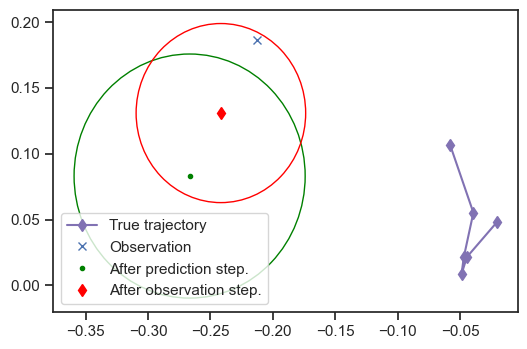

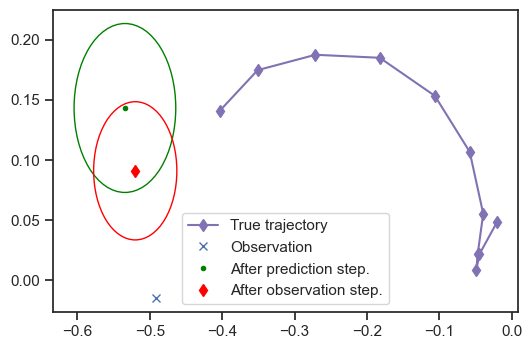

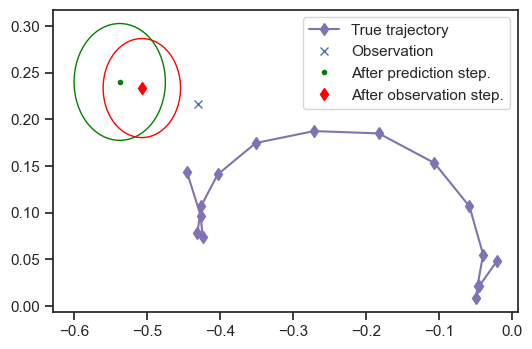

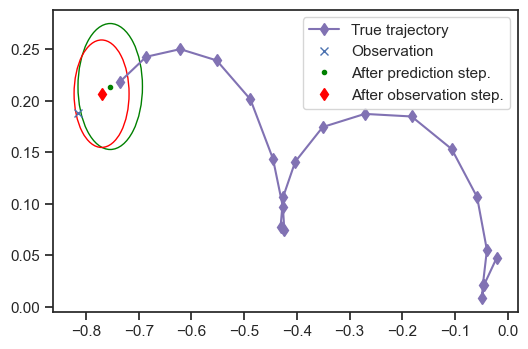

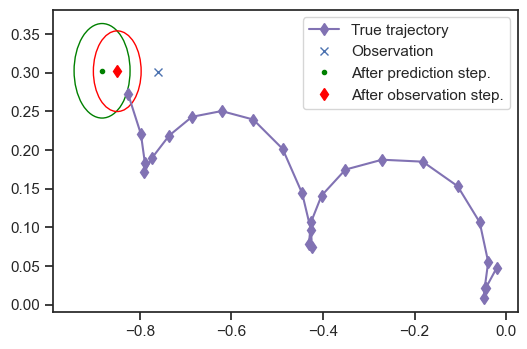

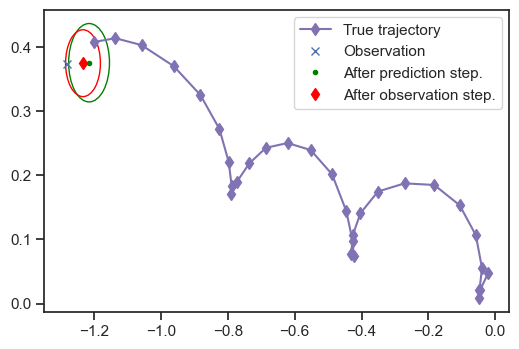

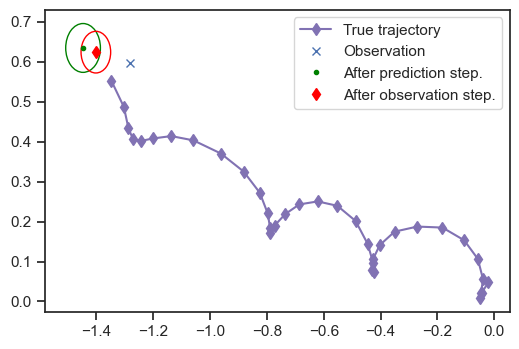

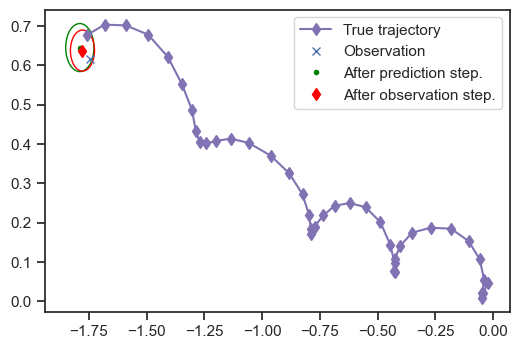

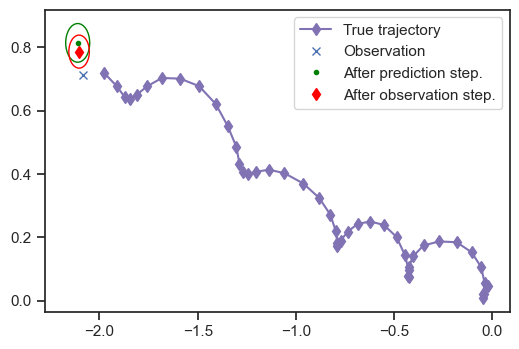

In [9]:
# DO NOT RERUN THIS WITHOUT RERUNNING THE INITIALIZATION CODE IN THE PREVIOUS
# CODE BLOCK
for n in range(1, num_steps):
    # Predict step (notice that you also need to pass the control (if there is any))
    kf.predict(u=us[n])
    # Make a figure one every few time steps
    if n % 5 == 0:
        ax = plot_after_prediction_step(
            kf,
            true_trajectory=true_trajectory,
            observations=observations
        )
    # Update step
    kf.update(observations[n])
    if n % 5 == 0:
        plot_mean_and_ellipse(
            kf.x,
            kf.P,
            ax,
            style="d",
            color="red",
            label="After observation step."
        )
        plt.legend(loc='best')

Notice that the filter is very uncertain at the beginning.
Then it gradually becomes better and better.

The other way to run the filter is with all the data at once.
This is called a *batch* filter.
Here is how:

In [10]:
# We need to reset the initial conditions
kf.x = mu0
kf.P = V0
# Here is the code that runs the batch:
means, covs, _, _ = kf.batch_filter(observations, us=us)

This returns the means and the covariances that you would have gotten at each timestep:

In [11]:
means

array([[ 1.801e-02,  8.119e-02,  4.766e-02,  6.186e-02],
       [ 6.422e-02,  1.046e-01,  7.810e-02,  1.044e-01],
       [ 8.217e-04,  1.128e-01, -6.245e-03,  1.223e-01],
       [-5.568e-03,  1.415e-01, -4.864e-02,  1.324e-01],
       [-1.522e-01,  7.517e-02, -1.623e-01,  6.344e-02],
       [-2.243e-01,  1.411e-01, -1.986e-01,  4.975e-02],
       [-3.193e-01,  1.850e-01, -2.123e-01,  1.001e-02],
       [-3.653e-01,  1.982e-01, -1.742e-01, -3.444e-02],
       [-4.711e-01,  1.796e-01, -1.403e-01, -6.434e-02],
       [-4.939e-01,  1.674e-01, -7.447e-02, -5.766e-02],
       [-5.186e-01,  9.019e-02, -2.996e-02, -4.386e-02],
       [-4.721e-01,  5.596e-02,  4.852e-03, -1.860e-04],
       [-4.547e-01,  2.732e-02, -5.929e-03,  3.848e-02],
       [-4.773e-01,  8.535e-02, -5.246e-02,  7.988e-02],
       [-4.904e-01,  1.869e-01, -9.840e-02,  9.893e-02],
       [-5.090e-01,  2.309e-01, -1.294e-01,  6.785e-02],
       [-5.811e-01,  2.568e-01, -1.471e-01,  1.781e-02],
       [-6.600e-01,  2.740e-01,

And here is an alternative way to visualize your uncertainty about the state at all times:

In [12]:
def plot_kf_estimates(means, covs):
    """Plot estimates of the state with 95% credible intervals."""
    y_labels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$']

    dpi = 150
    
    res_x = 1024
    res_y = 768

    w_in = res_x / dpi
    h_in = res_y / dpi

    fig, ax = plt.subplots(4, 1)
    fig.set_size_inches(w_in, h_in)

    times = Dt * np.arange(num_steps + 1)

    for j in range(4):
        ax[j].set_ylabel(y_labels[j])
    ax[-1].set_xlabel('$t$ (time)')

    for j in range(4):
        ax[j].plot(
            times[0:num_steps],
            true_trajectory[0:num_steps, j],
            'b.-'
        )
        ax[j].plot(
            times[1:num_steps],
            means[1:num_steps, j],
            'r.'
        )
        ax[j].fill_between(
            times[1:num_steps],
            (
                means[1:num_steps, j]
                - 2.0 * np.sqrt(covs[1:num_steps, j, j])
            ),
            (
                means[1:num_steps, j]
                + 2.0 * np.sqrt(covs[1:num_steps, j, j])
            ),
            color='red',
            alpha=0.25
        )                
        if j < 2:
            ax[j].plot(
                times[1:num_steps],
                observations[:n, j],
                'go'
            )

Here is how to use it:

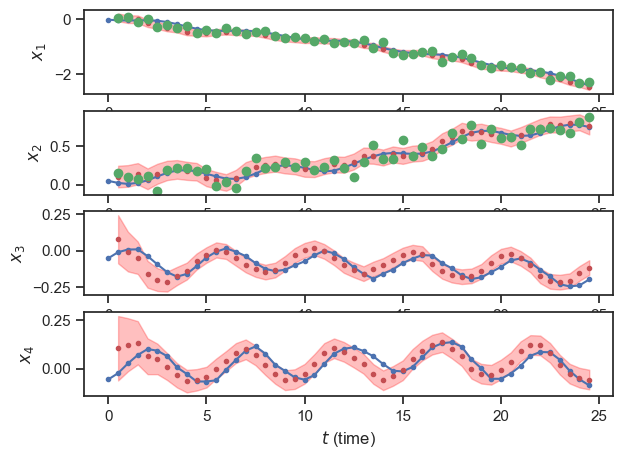

In [13]:
plot_kf_estimates(means, covs)

## Questions

+ Rerun the code a couple of times to observe different trajectories.
+ Double the process noise variance $\sigma_q^2$. What happens?
+ Double the measurement noise variance $\sigma_r^2$. What happens?
+ Zero-out the control vector $\mathbf{u}_{0:n-1}$. What happens?